In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [95]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data.head()
print(data.SalePrice.shape)

(1460,)


In [96]:
y= data.SalePrice
X=data.drop(['SalePrice'],axis =1)

In [97]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size =0.8, test_size = 0.2, random_state = 1)


In [98]:
#Assign categorical columns with unique values less than 10
categorical_cols = [cname for cname in X_train.columns if 
                    X_train[cname].nunique()< 10 and 
                    X_train[cname].dtypes == 'object']

#Assign numerical columns
numerical_cols = [cname for cname in X_train.columns if
                 X_train[cname].dtypes in ['int64','float64']]

#Keep selected columns only
features = categorical_cols + numerical_cols
X_train = X_train[features].copy()
X_test = X_test[features].copy()
test_data = test_data[features].copy()



In [114]:
print(X_test.shape)
print(X_train.shape)

X_train.head()

(292, 77)
(1168, 77)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
921,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,...,0,0,70,0,0,0,0,0,9,2008
520,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,0,220,114,210,0,0,0,0,8,2008
401,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,400,0,0,0,0,0,0,0,7,2006
280,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,575,0,84,0,196,0,0,0,1,2007
1401,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,398,100,75,0,0,0,0,0,4,2008


In [100]:

#Preprocess numerical data
numerical_transformer = SimpleImputer(strategy = 'mean')

#Preprocess categorical data
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

#Bundle numerical and categorical preprocessing
preprocessor = ColumnTransformer(
transformers = [
    ('num', numerical_transformer, numerical_cols),
    ('cat',categorical_transformer, categorical_cols)
])


In [101]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 200, random_state=0)

In [102]:
from sklearn.metrics import mean_absolute_error
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                               ('model', model)])


In [103]:
my_pipeline.fit(X_train,y_train)
preds = my_pipeline.predict(X_test)
score = mean_absolute_error(y_test,preds)
score

16476.201780821917

In [104]:
#Create a function that will calculate score for RandomForestRegressor with certain n_estimators
from sklearn.model_selection import cross_val_score
def get_score(n_estimators):
    pipeline= Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('model',RandomForestRegressor(n_estimators = n_estimators, random_state =0))
    ])
    
    score = -1 * cross_val_score(pipeline, X_train, y_train, cv =3, scoring = 'neg_mean_absolute_error')
    return score.mean()
    pass

In [105]:
# #Optimize the model
# score_results= {}
# for i in range(1,9):
#     score_results[i*50] = get_score(i*50)
# print(score_results)

#The optimal n_estimates is 200

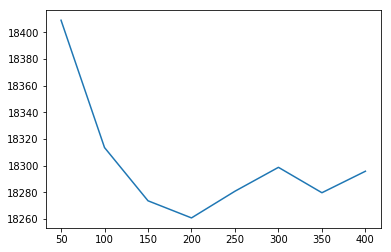

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(score_results.keys(), score_results.values())
plt.show()

In [113]:
#Predict 
preds = my_pipeline.predict(test_data)

output = pd.DataFrame({'Id': test_data.Id,
                      'SalePrice': preds})
output.to_csv('submission.csv', index=False)